# Discovery of Non-Linear Double Pendulum Dynamics using SODAs

This notebook documents the process of discovering the equations of motiona non-linear pendulum (away from small angle approximations) from pixel data of a video footage of swining pendulum with different initial conditions. The animations used for this analysis are created from . 

## Details of the Animation
- **Numerical Method**: Runge-Kutta adaptive method
- **Initial Time Step**: 0.0025
- **Damping**: 0.5
- **Frame Rate**: 60 Hz (recorded using QuickTime Player which supports 60 fps recording)

## Workflow
1. **Loading Video Footage**: The video footage of the pendulum is loaded using `cv2`, an open-source computer vision package in Python.
2. **Tracking the Pendulum Bob**: The x and y coordinates of the pendulum bob are tracked. The pivot point is centered at the origin.
3. **Normalization**: The length of the pendulum is normalized to be 1.
4. **Data Processing**: SODAs is applied to the (x,y) coordinates to find the algebraic constraints in the system using.
5. **Equation Discovery**: After the coordinat system is discovered, we transition into polar coordinates where the appropriate library functions are craeted to discover the polar equation of the pendulum.

In [1]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))


import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import sympy
from dae_finder import construct_reduced_fit_list

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp




from matplotlib import pyplot as plt
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from dae_finder import get_simplified_equation_list
from dae_finder import get_refined_lib, remove_paranth_from_feat
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder
from dae_finder import PolyFeatureMatrix
from copy import deepcopy



/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder


# Tracking from Pendulum video footage

- Run this section only once to get the (x,y) coordinates. 
- If this section is ran once, move to Loading of data directly.

### Finding the reference point (hook of pendulum)

In [ ]:
import cv2
import numpy as np

def pick_color(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Left mouse click
        pixel = frame[y, x]
        hsv_pixel = cv2.cvtColor(np.uint8([[pixel]]), cv2.COLOR_BGR2HSV)[0][0]
        print(f"HSV Color at ({x}, {y}): {hsv_pixel}")
ind = 1
video_path = "double_pendulum_{}.mov".format(ind)
cap = cv2.VideoCapture(video_path)

cv2.namedWindow("Frame")
cv2.setMouseCallback("Frame", pick_color)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Frame", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


HSV Color at (964, 750): [  0   0 138]
HSV Color at (964, 750): [  0   0 125]
HSV Color at (963, 750): [  0   0 178]
HSV Color at (963, 750): [  0   0 182]
HSV Color at (963, 750): [  0   0 180]


### Tracking the pendulum

In [1]:
import cv2
import numpy as np
import pandas as pd

# Define HSV color range for the pendulum bob (Replace with detected values)
lower_color = np.array([120, 255, 243])  # Adjust as needed
upper_color = np.array([120, 255, 243])  # Adjust as needed

for ind in [3]:
    video_path = "double_pendulum_{}.mov".format(ind)

    cap = cv2.VideoCapture(video_path)

    # Get FPS (frames per second) from video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_time = 1 / fps  # Time interval between frames

    # List to store detected coordinates with time for both bobs
    positions = []
    frame_count = 0  # To track frame number

    # Initialize previous bob positions for tracking identity
    prev_bob1 = None  # (x1, y1)
    prev_bob2 = None  # (x2, y2)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1  # Track frame number
        time = frame_count * frame_time  # Compute time in seconds

        # Convert frame to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Create a mask for the pendulum bob's color
        mask = cv2.inRange(hsv, lower_color, upper_color)

        # Perform morphological operations to clean the mask
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Find contours from the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) >= 2:
            # Sort contours by area (assuming the two largest are the bobs)
            contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

            bobs = []
            for contour in contours:
                # Get bounding box
                x, y, w, h = cv2.boundingRect(contour)

                # Calculate center of the bounding box
                center_x = x + w // 2
                center_y = y + h // 2
                bobs.append((center_x, center_y))

            # Use tracking to maintain identity
            if prev_bob1 is None or prev_bob2 is None:
                # First frame: assign bobs based on Y-coordinate
                bobs = sorted(bobs, key=lambda c: c[1])
                bob1, bob2 = bobs[0], bobs[1]
            else:
                # Compute distances from previous positions
                d1 = np.linalg.norm(np.array(bobs[0]) - np.array(prev_bob1))
                d2 = np.linalg.norm(np.array(bobs[1]) - np.array(prev_bob1))

                # Assign IDs based on closest match
                if d1 < d2:
                    bob1, bob2 = bobs[0], bobs[1]
                else:
                    bob1, bob2 = bobs[1], bobs[0]

            # Update previous positions
            prev_bob1, prev_bob2 = bob1, bob2

            # Store time and coordinates
            positions.append([time, bob1[0], bob1[1], bob2[0], bob2[1]])

            # Draw tracking markers
            cv2.circle(frame, (bob1[0], bob1[1]), 5, (0, 255, 0), -1)  # First bob (green)
            cv2.circle(frame, (bob2[0], bob2[1]), 5, (0, 0, 255), -1)  # Second bob (red)

            # Display coordinates
            cv2.putText(frame, f"({bob1[0]}, {bob1[1]})", (bob1[0] + 10, bob1[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            cv2.putText(frame, f"({bob2[0]}, {bob2[1]})", (bob2[0] + 10, bob2[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Show the tracking result
        cv2.imshow("Double Pendulum Tracking", frame)

        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Convert positions to a DataFrame and save as CSV
    df = pd.DataFrame(positions, columns=["t", "X1", "Y1", "X2", "Y2"])
    df.to_csv("double_pendulum_{}.csv".format(ind), index=False)

    print("Double pendulum position data saved to double_pendulum_{}.csv".format(ind))


Double pendulum position data saved to double_pendulum_3.csv


## Loading data

In [2]:

# Loading pendulum data
df_list = []
for ind in [3]:
    file_path = f"double_pendulum_{ind}.csv"
    df = pd.read_csv(file_path)
    df_list.append(df)

# trimming_slices=  [(10,700), (10,700), (10,700), (10,700), (10,700)]
# trimming_slices=  [(0,100), (0,100), (0,100), (0,100), (0,100)]
trimming_slices = [(2,-2), (2,-2)]


df_trimmed = []
for df_, slice in zip(df_list, trimming_slices):
    df_trimmed.append(df_[slice[0]:slice[1]].reset_index(drop=True))

#centering the hook of pendulum to origin
center = (963.5, 750)
color = [120, 255, 243]
for df_ in df_trimmed:
    df_["x_1"] = df_["X1"] - center[0]
    df_["y_1"] = -(df_["Y1"] - center[1])
    df_["x_2"] = df_["X2"] - center[0]
    df_["y_2"] = -(df_["Y2"] - center[1])


# for i, df in enumerate(df_trimmed):
#     df.to_csv(f"double_pendulum_trimmed_{i+1}.csv", index=False)

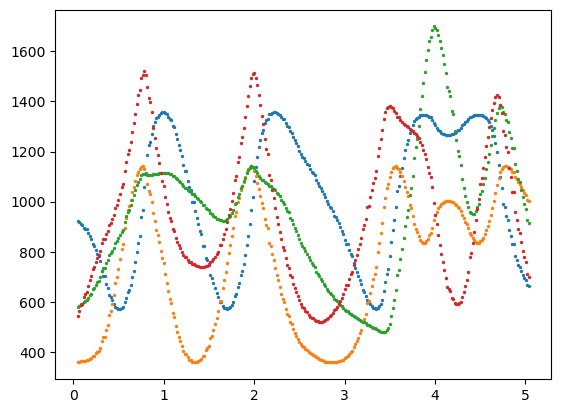

In [127]:
L=1  
smoothening_window_size = 15
pen_orig_len = abs(df_trimmed[0]["y_1"]).max()
#Scaling the pendulum length to L
for df_ in df_trimmed:
    df_["x_1"] = (df_["x_1"]/pen_orig_len) * L
    df_["y_1"] = (df_["y_1"]/pen_orig_len) * L
    df_["x_2"] = (df_["x_2"]/pen_orig_len) * L
    df_["y_2"] = (df_["y_2"]/pen_orig_len) * L

    # df_["x"] = df_["x"].rolling(window=smoothening_window_size, center=True).mean()
    # df_["y"] = df_["y"].rolling(window=smoothening_window_size, center=True).mean()

    # df_["theta"] = np.arctan2(df_["y"], df_["x"])
    # df_["theta"] = (np.arctan2(df_["y"], df_["x"])).rolling(window=smoothening_window_size, center=True).mean()
    # df_.dropna(ignore_index=True, inplace=True)

df_appended = pd.concat(df_trimmed, ignore_index=True)

for df_ in df_trimmed:

    # df_[["x_1", "y_1", "x_2", "y_2"]][:100].plot()
    # for feat in ["x_1", "y_1", "x_2", "y_2"]:
    for feat in ["X1", "Y1", "X2", "Y2"]:
        plt.scatter(df_["t"][:300], df_[feat][:300], s=2)
        # plt.plot(df_["t"][:300], df_[feat][:300], ".-")

    # df_[["x_2", "y_2"]].plot()



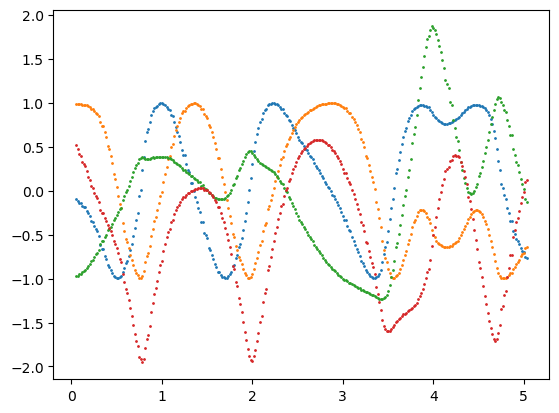

In [129]:
for feat in ["x_1", "y_1", "x_2", "y_2"]:
    plt.scatter(df_["t"][:300], df_[feat][:300], s=1)

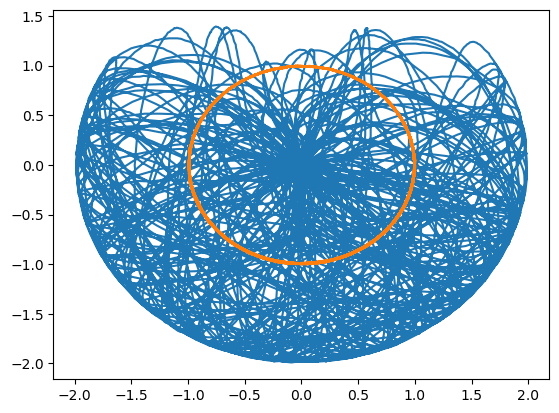

In [4]:
for df_ in df_trimmed:
    plt.plot(df_["x_2"], df_["y_2"])
    plt.plot(df_["x_1"], df_["y_1"])


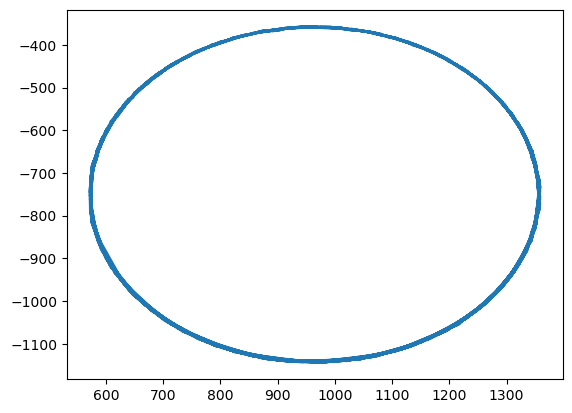

In [5]:
for df_ in df_trimmed:
    plt.plot(df_["X1"], -df_["Y1"])

In [6]:
(df_appended["x_1"]**2+df_appended["y_1"]**2).mean()

0.9902473796096585

In [7]:
(df_appended["x_1"]**2+df_appended["y_1"]**2).std()

0.005745321797176402

<Axes: >

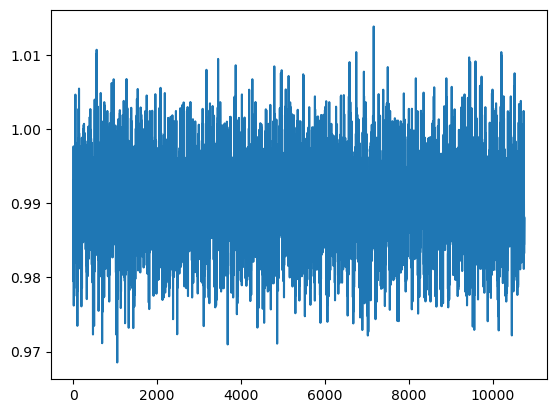

In [8]:
#Visualizing the algebraic constrain in the system
(df_appended["x_1"]**2+df_appended["y_1"]**2).plot()

<Axes: >

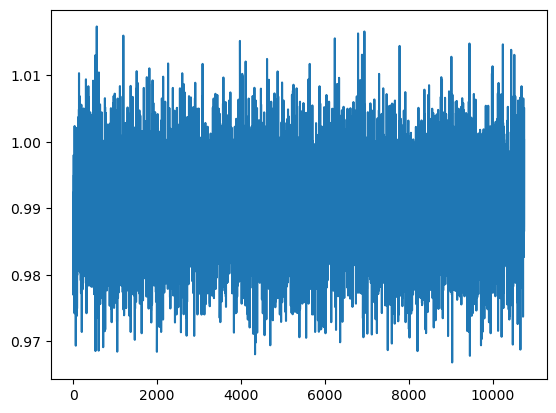

In [9]:
((df_appended["x_1"]-df_appended["x_2"])**2+(df_appended["y_1"]-df_appended["y_2"])**2).plot()

### Smoothening data using Savitzky-Golay Filer

In [10]:
# Finding the first and second order derivative of the states using Savitzky-Golay Filer

data_matrix_smooth_df_list = [
    smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=2,
                polyorder=2,
                window_smooth=None) #trimming zero derivatives near end points
    for data_matrix in df_trimmed]



if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_new= data_matrix_df_smooth_appended[["x_1", "y_1"]]


# data_matrix_df_new = data_matrix_df_new.rename(columns= dict(zip(data_matrix_df_new, ['theta', 'theta_dot'])))

## Fomring the candidate library

In [130]:
data_matrix_df_new = df_appended[["x_1", "y_1", "x_2", "y_2"]]
# data_matrix_df_new["Y"] = -data_matrix_df_new["Y"]


poly_degree = 3
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

#Optionally removing features from the library
terms_to_drop_corr = set()
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))


Degree of library: 3
# terms in the library: 34
Full candidate library has the following features: Index(['x_1', 'y_1', 'x_2', 'y_2', 'x_1^2', 'x_1 y_1', 'x_1 x_2', 'x_1 y_2',
       'y_1^2', 'y_1 x_2', 'y_1 y_2', 'x_2^2', 'x_2 y_2', 'y_2^2', 'x_1^3',
       'x_1^2 y_1', 'x_1^2 x_2', 'x_1^2 y_2', 'x_1 y_1^2', 'x_1 y_1 x_2',
       'x_1 y_1 y_2', 'x_1 x_2^2', 'x_1 x_2 y_2', 'x_1 y_2^2', 'y_1^3',
       'y_1^2 x_2', 'y_1^2 y_2', 'y_1 x_2^2', 'y_1 x_2 y_2', 'y_1 y_2^2',
       'x_2^3', 'x_2^2 y_2', 'x_2 y_2^2', 'y_2^3'],
      dtype='object')


## Finding algebraic relationships

In [131]:
from daeFinder import sequentialThLin
from daeFinder import AlgModelFinder
from daeFinder import remove_paranth_from_feat
# Adding the state variables as scipy symbols
# feat_list = list(data_matrix_df_smooth_appended.columns)
feat_list = ["x_1","y_1", "x_2", "y_2"]
feat_list_str = ", ".join(remove_paranth_from_feat(feat_list))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")


down_size = 1000
candidate_lib_downsized = candidate_lib_full.iloc[::down_size, :].reset_index(drop=True)


# seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)

# seq_th_model = sequentialThLin(model_id="LR", coef_threshold= 0.2)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(candidate_lib_downsized, scale_columns= True)

algebraic_model_th.best_models()

Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential th

,x_1,y_1,x_1^2,y_1^2,x_1 y_2^2,y_2,y_1 y_2^2,x_2,x_1 x_2 y_2,y_1^2 y_2,...,x_1 y_1 y_2,y_1 x_2 y_2,x_1 x_2^2,x_2^2,y_1 x_2,y_1^3,x_1^3,x_1^2 x_2,x_1 y_1,x_1 y_1 x_2
y_1,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.21968187,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.14631088,0.00000000,0.00000000,0.00000000,0.00000000
x_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.08752445,0.00000000,0.00000000,0.00000000,0.00000000
x_1^2,0.00000000,0.00000000,NaN,-0.99055147,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.39218286,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x_1 y_1,0.00000000,0.00000000,0.00000000,0.00000000,-0.96664075,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,-0.16909906,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.64919293,0.00000000,NaN,0.00000000
x_1 x_2,0.00000000,0.00000000,0.00000000,0.00000000,-0.31679033,0.00000000,0.00000000,-0.23792281,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.89978251,0.00000000,0.00000000,0.00000000,-0.49306178,0.00000000,0.00000000
x_1 y_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.17829725,0.00000000,0.35597090,0.00000000
y_1^2,0.00000000,0.00000000,-0.97363979,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,-0.32983492,0.00000000,0.35405118,0.00000000,0.00000000,0.00000000
y_1 x_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,-0.62046400,NaN,0.00000000,0.00000000,0.00000000,0.00000000,-0.12868473
y_1 y_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.31847611,0.00000000,0.00000000,-0.20041832,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [18]:
# dict(zip(lin_model.feature_names_in_, lin_model.coef_))

In [19]:
# from sklearn.linear_model import LinearRegression

# lin_model = LinearRegression(fit_intercept=True)
# lin_model.fit(X=candidate_lib_downsized[["y", "y^2"]], y=candidate_lib_downsized["x^2"])
# lin_model.score(X=candidate_lib_downsized[["y", "y^2"]], y=candidate_lib_downsized["x^2"])

In [20]:
# dict(zip(lin_model.feature_names_in_, lin_model.coef_))

## Refine library

In [42]:
features_to_remove = {x_1**2}
# features_to_remove = {y**2, y*y_dot}


features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

In [97]:
down_size = 2000
candidate_lib_downsized = refined_candid_lib.iloc[::down_size, :].reset_index(drop=True)


seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.02)
# seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.5, coef_threshold= 0.05)

# seq_th_model = sequentialThLin(model_id="LR", coef_threshold= 0.2)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(candidate_lib_downsized, scale_columns= True)

algebraic_model_th.best_models()

Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential th

,y_1 y_2^2,x_2^2 y_2,x_2 y_2^2,y_1 x_2 y_2,x_2 y_2,x_2^3,y_1 y_2,y_1 x_2^2,x_1 y_1^2,x_2,...,y_1,x_2^2,x_1 x_2,y_1^2 x_2,y_1 x_2,x_1 y_2,y_1^3,y_1^2,x_1 x_2 y_2,x_1 y_1
x_1,-0.03479966,0.00000000,0.07182451,0.00000000,-0.15822662,0.18081272,0.11852758,0.00000000,0.01839136,0.00000000,...,0.00000000,0.10222163,-0.05076809,-0.04905021,-0.21770134,-0.05561872,0.06749334,0.20950556,0.01268637,0.03583918
y_1,0.06033452,0.08211976,-0.03518935,-0.10187196,0.00000000,0.00000000,-0.02170424,0.13109130,-0.00609691,-0.13192775,...,NaN,-0.06032589,0.00000000,-0.18565849,0.00000000,-0.04695792,0.21179897,0.00000000,-0.02175161,-0.02845106
x_2,-0.02691833,-0.02421209,0.02972831,0.03853224,-0.01445434,0.34719588,0.01602883,-0.10824932,0.00000000,NaN,...,-0.05206336,-0.14265900,-0.08857509,0.08120922,0.02320401,-0.02902397,-0.07048107,0.01062865,0.01597106,-0.01079796
y_2,0.06092900,0.09419365,-0.04552831,-0.07116681,0.00000000,0.00000000,0.00000000,0.06183999,-0.02400137,0.00000000,...,0.14046958,-0.04925950,-0.08204980,-0.08544703,0.00000000,-0.11980181,0.10572503,0.04772973,0.05802250,-0.05996017
x_1 y_1,0.12465314,0.31592040,-0.50495424,-0.19813143,0.00000000,0.68755817,0.20160277,0.00000000,0.07329749,-0.27874196,...,-0.34653705,-0.19441116,-0.07359200,-0.20490070,-0.43692790,1.09955557,0.10008077,0.44422465,0.00000000,NaN
x_1 x_2,-0.02342198,-0.09146438,0.03956011,0.03363772,0.02656540,-0.86116886,-0.03278584,0.13318080,0.01567178,-0.26740134,...,0.00000000,0.55980440,NaN,0.00000000,-0.04724294,0.05293274,0.00000000,-0.08351150,-0.07427199,-0.00826576
x_1 y_2,0.04552027,0.06744766,-0.17377544,-0.06405425,0.17667240,0.00000000,-0.04521974,0.00000000,0.01847453,-0.14388089,...,-0.11258096,-0.07835712,0.09002314,0.00000000,0.06623683,NaN,0.00000000,-0.08419845,-0.04383625,0.22071919
y_1^2,0.00000000,0.06151844,0.00000000,0.00000000,-0.23843249,0.20025379,0.20737749,0.00000000,0.00000000,0.06191500,...,0.00000000,0.15938447,-0.16246529,-0.03753037,-0.42211207,-0.08829391,0.05322576,NaN,0.13591259,0.08947910
y_1 x_2,0.03303457,0.00000000,0.00000000,0.00000000,0.18981720,0.27744654,-0.15653245,-0.06169296,-0.01845802,0.08972264,...,0.00000000,-0.45247642,-0.07024593,0.04295588,NaN,0.04399663,-0.02907515,-0.30888598,-0.05545129,-0.06666669
y_1 y_2,-0.05553767,-0.04702262,0.08712564,0.05475157,-0.15312963,0.30539064,NaN,-0.06866256,0.01975613,0.08360866,...,-0.04775395,0.07997791,-0.06181537,0.00000000,-0.20592831,-0.04871790,0.00000000,0.20339691,0.01816453,0.03868247


In [98]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression(fit_intercept=True)

best_exp = algebraic_model_th.best_models(1)
best_exp = algebraic_model_th.best_models(1)
best_lhs = best_exp.columns[0]
best_rhs = list(best_exp[best_lhs][abs(best_exp[best_lhs]) > 0.04].index)[:-1]


# lin_model.fit(X=candidate_lib_downsized[best_rhs], y=candidate_lib_downsized[best_lhs])
# lin_model.score(X=candidate_lib_downsized[best_rhs], y=candidate_lib_downsized[best_lhs])

lin_model.fit(X=candidate_lib_full[best_rhs], y=candidate_lib_full[best_lhs])
lin_model.score(X=candidate_lib_full[best_rhs], y=candidate_lib_full[best_lhs])

0.9999773173706032

In [99]:
len(candidate_lib_downsized)

6

In [100]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'y_1': 0.0012435682485427196,
 'y_2': -0.000843809428523631,
 'x_1 y_1': -0.00014130143567660185,
 'x_1 y_2': 0.0017758094527591949,
 'y_1 y_2': -0.0011920635372497789,
 'y_2^2': -0.0001290411811707158,
 'x_1 y_1^2': 6.547642845285258e-05,
 'x_1 y_1 x_2': -0.0001861742197433845,
 'x_1 y_1 y_2': 0.0004195426458370212,
 'x_1 x_2 y_2': -0.9972208577225944,
 'x_1 y_2^2': 5.8033848563934754e-05,
 'y_1^3': -0.0016065515610555914,
 'y_1^2 x_2': 0.00015317808934175807,
 'y_1^2 y_2': 0.0026825839373472342,
 'y_1 x_2 y_2': -0.00037831766786072265,
 'x_2^2 y_2': 0.4987745413354929,
 'x_2 y_2^2': 6.776410392449815e-05,
 'y_2^3': 0.49931319886807196}

### Parameter fitting after discovery

In [56]:
lin_model.fit(X=candidate_lib_full[["x_1 y_1 x_2","y_1^2 y_2","y_1 x_2^2", "y_1 y_2^2", "y_2^2", "x_1 x_2", "x_2^2"]], y=candidate_lib_full["y_1 y_2"])
lin_model.score(X=candidate_lib_full[["x_1 y_1 x_2","y_1^2 y_2","y_1 x_2^2", "y_1 y_2^2", "y_2^2", "x_1 x_2", "x_2^2"]], y=candidate_lib_full["y_1 y_2"])

0.9999368446548872

In [57]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'x_1 y_1 x_2': -0.5937979857052728,
 'y_1^2 y_2': -0.594637370164976,
 'y_1 x_2^2': 0.296464507117517,
 'y_1 y_2^2': 0.2967624597612537,
 'y_2^2': 0.4996671047122556,
 'x_1 x_2': -0.9989911450726969,
 'x_2^2': 0.49957502693526634}

In [101]:
lin_model.fit(X=candidate_lib_full[["x_1 x_2", "y_2^2", "y_1 y_2", "x_2^2"]], y=candidate_lib_full["y_1^2"])
lin_model.score(X=candidate_lib_full[["x_1 x_2", "y_2^2", "y_1 y_2", "x_2^2"]], y=candidate_lib_full["y_1^2"])

0.644033223755824

In [102]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'x_1 x_2': -0.04775271102070344,
 'y_2^2': -0.42273654097485325,
 'y_1 y_2': 0.9725883611722245,
 'x_2^2': -0.05581679262511003}

In [98]:
from daeFinder import FeatureCouplingTransformer
from scipy.sparse import coo_array



coupling_matrix_init = np.zeros((4,4))
coupling_matrix_init[0,2] = 1
coupling_matrix_init[1,3] = 1


sparse_coupling_matrix_init = coo_array(coupling_matrix_init)
sparse_coupling_matrix_init.toarray()

def coup_fun_diff(x,y,i,j):
    return x-y

def coup_namer_diff(x,y,i,j,gam_matrix=None):
    return "({}-{})".format(x,y)


# def coup_fun_diff(x,y,i,j,gam_matrix):
#     return x-y- gam_matrix[i,j]

# def coup_namer_diff(x,y,i,j,gam_matrix):
#     return "{}-{} -gamma_{},{}".format(x,y,i,j)

transfomrer_diff = FeatureCouplingTransformer(sparse_coupling_matrix_init,
                                            coupling_func= coup_fun_diff,
                                            coupling_namer= coup_namer_diff,
                                                return_df=True)

# transformer_diff = FeatureCouplingTransformer(sparse_coupling_matrix_init,
#                                            coupling_func= coup_fun_diff,
#                                            coupling_namer= coup_namer_diff,
#                                            coupling_func_args={"gam_matrix":gamma_matrix},
#                                               return_df=True)


# In[38]:


# In[39]:

data_matrix_df_new = df_appended[["x_1", "y_1", "x_2", "y_2"]]
#Creating library with sin(load angle difference)
diff_library = transfomrer_diff.fit_transform(data_matrix_df_new)
data_matrix_df_new = pd.concat([data_matrix_df_new, diff_library], axis=1).reset_index(drop=True)

In [99]:
data_matrix_df_new

,x_1,y_1,x_2,y_2,(x_1-x_2),(y_1-y_2)
0,-0.30759494,-0.93924051,-0.21898734,-1.93670886,-0.08860759,0.99746835
1,-0.31518987,-0.94177215,-0.34556962,-1.93670886,0.03037975,0.99493671
2,-0.31518987,-0.94177215,-0.52531646,-1.91139241,0.21012658,0.96962025
3,-0.31518987,-0.93417722,-0.62911392,-1.88101266,0.31392405,0.94683544
4,-0.31012658,-0.94177215,-0.74556962,-1.83291139,0.43544304,0.89113924
...,...,...,...,...,...,...
1430,-0.18354430,-0.97215190,-1.10253165,-1.35189873,0.91898734,0.37974684
1431,-0.11265823,-0.98734177,-1.03924051,-1.34177215,0.92658228,0.35443038
1432,-0.03164557,-0.99493671,-0.95822785,-1.34177215,0.92658228,0.34683544
1433,0.04936709,-0.99240506,-0.87974684,-1.34430380,0.92911392,0.35189873


## Fomring the candidate library

In [100]:
# data_matrix_df_new["Y"] = -data_matrix_df_new["Y"]

poly_degree = 2
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

#Optionally removing features from the library
terms_to_drop_corr = set()
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))


Degree of library: 2
# terms in the library: 27
Full candidate library has the following features: Index(['x_1', 'y_1', 'x_2', 'y_2', '(x_1-x_2)', '(y_1-y_2)', 'x_1^2',
       'x_1 y_1', 'x_1 x_2', 'x_1 y_2', 'x_1 (x_1-x_2)', 'x_1 (y_1-y_2)',
       'y_1^2', 'y_1 x_2', 'y_1 y_2', 'y_1 (x_1-x_2)', 'y_1 (y_1-y_2)',
       'x_2^2', 'x_2 y_2', 'x_2 (x_1-x_2)', 'x_2 (y_1-y_2)', 'y_2^2',
       'y_2 (x_1-x_2)', 'y_2 (y_1-y_2)', '(x_1-x_2)^2', '(x_1-x_2) (y_1-y_2)',
       '(y_1-y_2)^2'],
      dtype='object')


## Finding algebraic relationships

In [103]:
from daeFinder import sequentialThLin
from daeFinder import AlgModelFinder
from daeFinder import remove_paranth_from_feat
# Adding the state variables as scipy symbols
# feat_list = list(data_matrix_df_smooth_appended.columns)
feat_list = ["x_1","y_1", "x_2", "y_2"]
feat_list_str = ", ".join(remove_paranth_from_feat(feat_list))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")


down_size = 10
candidate_lib_downsized = candidate_lib_full.iloc[::down_size, :].reset_index(drop=True)


# seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)

# seq_th_model = sequentialThLin(model_id="LR", coef_threshold= 0.2)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(candidate_lib_full, scale_columns= True)

algebraic_model_th.best_models()

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

,x_2 y_2,y_2 (x_1-x_2),x_2^2,y_2^2,y_1 x_2,y_2 (y_1-y_2),x_2 (y_1-y_2),x_1 y_2,x_2 (x_1-x_2),y_1 (y_1-y_2),...,(x_1-x_2) (y_1-y_2),(x_1-x_2),x_1,y_1,x_1 x_2,y_1 y_2,y_1^2,x_1^2,(y_1-y_2)^2,(x_1-x_2)^2
x_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.99942613,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,-0.99959308,0.99950876,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.99902224,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
(x_1-x_2),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,NaN,0.99934056,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
(y_1-y_2),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.99902873,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x_1^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.36582766,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.61181839,-0.20207572,-0.53186061,NaN,0.00000000,0.00000000
x_1 y_1,0.33412396,0.28364456,0.00000000,0.00000000,0.64062774,0.00000000,0.25646110,0.69001724,0.00000000,0.00000000,...,0.21554394,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x_1 x_2,0.00000000,0.00000000,0.99991522,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.16591013,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,-0.09467217,0.29634838,0.00000000,-0.07676770
x_1 y_2,0.32833539,0.19622285,0.00000000,0.00000000,0.14162100,0.00000000,-0.24430044,NaN,0.00000000,0.00000000,...,-0.17866380,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [104]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=candidate_lib_downsized[["y", "x^2", "y^3"]], y=candidate_lib_downsized["y^2"])
lin_model.score(X=candidate_lib_downsized[["y", "x^2", "y^3"]], y=candidate_lib_downsized["y^2"])

KeyError: "None of [Index(['y', 'x^2', 'y^3'], dtype='object')] are in the [columns]"

In [ ]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'y': -0.557746124419649,
 'x^2': -0.10054568813662637,
 'y^3': -0.4550538428602588}

In [ ]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=candidate_lib_downsized[["y", "y^2"]], y=candidate_lib_downsized["x^2"])
lin_model.score(X=candidate_lib_downsized[["y", "y^2"]], y=candidate_lib_downsized["x^2"])

0.9993870501680048

In [ ]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'y': -0.4402889966017161, 'y^2': -0.9741632129661891}

## Refine library

In [ ]:
features_to_remove = {x_1**2}
# features_to_remove = {y**2, y*y_dot}


features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

In [ ]:
down_size = 1
candidate_lib_downsized = refined_candid_lib.iloc[::down_size, :].reset_index(drop=True)


# seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.5, coef_threshold= 0.05)

# seq_th_model = sequentialThLin(model_id="LR", coef_threshold= 0.2)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(candidate_lib_downsized, scale_columns= True)

algebraic_model_th.best_models()

Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential th

,y_1 y_2^2,x_2^3,x_2,x_1 x_2^2,y_2^3,y_1^2 y_2,x_1 x_2,x_2^2,y_1 x_2^2,y_1 y_2,...,y_2,y_1^2,y_1 x_2,y_1^3,x_2 y_2,x_1 y_2,y_1,x_1 y_1,x_1 y_1^2,x_1
x_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.19751468,-0.05623432,0.38717818,-0.33071373,0.04085043,-0.20201322,-0.05673525,NaN
y_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.18117017,...,-0.49702327,-0.42310451,0.00000000,0.08784700,-0.44184094,0.33023774,NaN,0.00000000,0.00000000,0.62453085
x_2,0.00000000,0.90208532,NaN,0.55214522,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,-0.18551063,0.00000000,-0.08641296,0.00000000,-0.03366294,0.12289297,0.10812686,0.31575037
y_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.13443257,...,NaN,-0.06571972,0.00000000,-0.07121539,0.19820414,-0.21396614,-0.30326412,0.03802659,0.02834615,-0.22760076
x_1 y_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,1.01215381,0.00000000,0.00000000,0.00000000,0.00000000,NaN,-0.82188757,-1.48771505
x_1 x_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,1.99814489,0.00000000,-0.71076281,...,0.00000000,0.10252621,0.00000000,0.00000000,0.16790633,-0.10751943,0.26586212,0.00000000,0.00000000,-0.15827914
x_1 y_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,-0.14202913,1.18256200,NaN,0.09581660,-0.07460350,0.08527628,-1.40049849
y_1^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.13276618,...,-0.20607698,NaN,0.00000000,-0.87834450,-0.14438649,0.09380070,-0.83673498,0.00000000,-0.10633096,0.25232240
y_1 x_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,NaN,0.00000000,0.00000000,-0.08356338,-0.04091383,0.66422997,0.57813849,0.93762483
y_1 y_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.99260064,1.98305510,0.00000000,NaN,...,-1.20394856,-0.27626562,0.00000000,0.08621808,-0.23383542,0.13375744,-0.83829636,0.00000000,0.00000000,0.32293280


In [74]:
algebraic_model_th.best_models()["x_1 y_1"]

ValueError: cannot set a frame with no defined columns

### Finding the first and second order derivative of the states using Savitzky-Golay Filer

In [10]:
# Finding the first and second order derivative of the states using Savitzky-Golay Filer

data_matrix_smooth_df_list = [
    smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=2,
                polyorder=2,
                window_smooth=None)[100:-100] #trimming zero derivatives near end points
    for data_matrix in df_trimmed]



if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_new= data_matrix_df_smooth_appended[["theta", "d(theta) /dt"]]


data_matrix_df_new = data_matrix_df_new.rename(columns= dict(zip(data_matrix_df_new, ['theta', 'theta_dot'])))

## Fomring the candidate library

In [12]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))

poly_degree = 4
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

#Optionally removing features from the library
terms_to_drop_corr = set()
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))

#Adding sin and cos terms using x and y
candidate_lib_full["cos(theta)"] = data_matrix_df_smooth_appended["x"]
candidate_lib_full["sin(theta)"] = data_matrix_df_smooth_appended["y"]

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder
Degree of library: 4
# terms in the library: 14
Full candidate library has the following features: Index(['theta', 'theta_dot', 'theta^2', 'theta theta_dot', 'theta_dot^2',
       'theta^3', 'theta^2 theta_dot', 'theta theta_dot^2', 'theta_dot^3',
       'theta^4', 'theta^3 theta_dot', 'theta^2 theta_dot^2',
       'theta theta_dot^3', 'theta_dot^4'],
      dtype='object')


In [13]:
# candidate_lib_full["sin(theta)"] = np.sin(candidate_lib_full["theta"])
# candidate_lib_full["cos(theta)"] = np.cos(candidate_lib_full["theta"])


# candidate_lib_full["x"] = df_trimmed[0][100:-100]["x"].reset_index(drop=True)
# candidate_lib_full["y"] = df_trimmed[0][100:-100]["y"].reset_index(drop=True)


<Axes: >

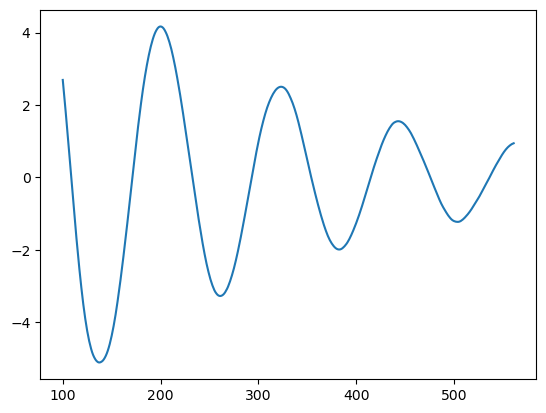

In [14]:
data_matrix_smooth_df_list[0]['d^2(theta) /dt^2'].plot()

In [15]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler with mean=False to keep the mean the same
scaler = StandardScaler(with_std=True, with_mean=False)

# Scale candidate_lib_full
candidate_lib_full_scaled = pd.DataFrame(scaler.fit_transform(candidate_lib_full), columns=candidate_lib_full.columns)

# Scale data_matrix_df_smooth_appended
data_matrix_df_smooth_appended_scaled = pd.DataFrame(scaler.fit_transform(data_matrix_df_smooth_appended), columns=data_matrix_df_smooth_appended.columns)



In [16]:
seq_th_model = sequentialThLin(model_id="lasso" ,fit_intercept=True, alpha=0.002, coef_threshold= 0.05)
# seq_th_model = sequentialThLin(model_id="lasso" ,fit_intercept=True, alpha=0.001, coef_threshold= 0.01)

# seq_th_model = sequentialThLin(fit_intercept=True, model_id="LR", coef_threshold= 0.05)

down_size = 10
X_downsampled = candidate_lib_full_scaled.iloc[::down_size, :].reset_index(drop=True)
y_downsampled = data_matrix_df_smooth_appended_scaled['d^2(theta) /dt^2'].iloc[::down_size].reset_index(drop=True)

seq_th_model.fit(X=X_downsampled, y=y_downsampled)
seq_th_model.score(X=X_downsampled, y=y_downsampled)
# data_matrix_df_smooth_appended["energy"] = 0.5*((data_matrix_df_smooth_appended["x_dot"])**2 + (data_matrix_df_smooth_appended["y_dot"])**2) +  9.81*data_matrix_df_smooth_appended["y"]
# smoothen_index = abs(data_matrix_df_smooth_appended["energy"]-data_matrix_df_smooth_appended["energy"].mean()) < 0.5*data_matrix_df_smooth_appended["energy"].std()
# seq_th_model.fit(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

# seq_th_model.score(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

Sequential threshold converged in 1 iterations


/Users/manujayadharan/opt/anaconda3/envs/pysindy_env_faster/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.495e-02, tolerance: 1.849e-02
  model = cd_fast.enet_coordinate_descent(
/Users/manujayadharan/opt/anaconda3/envs/pysindy_env_faster/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.662e-02, tolerance: 1.849e-02
  model = cd_fast.enet_coordinate_descent(
/Users/manujayadharan/opt/anaconda3/envs/pysindy_env_faster/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to 

0.9996011159062811

In [17]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'theta': -0.6811714581696067,
 'theta_dot': -0.1456941616743466,
 'theta^2': 0.0,
 'theta theta_dot': 0.0,
 'theta_dot^2': 0.0,
 'theta^3': 0.0,
 'theta^2 theta_dot': 0.0,
 'theta theta_dot^2': 0.0,
 'theta_dot^3': 0.0,
 'theta^4': 0.0,
 'theta^3 theta_dot': 0.0,
 'theta^2 theta_dot^2': 0.0,
 'theta theta_dot^3': 0.0,
 'theta_dot^4': 0.0,
 'cos(theta)': 0.3168380322242229,
 'sin(theta)': 0.0}

In [19]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=X_downsampled[["cos(theta)", "theta", "theta_dot"]], y=y_downsampled)
lin_model.score(X=X_downsampled[["cos(theta)","theta", "theta_dot"]], y=y_downsampled)

0.9998036870193455

In [20]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'cos(theta)': 1.0943242950651857,
 'theta': 0.09406394264109988,
 'theta_dot': -0.14470204446975535}

In [85]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=X_downsampled[["x", "theta_dot"]], y=y_downsampled)
lin_model.score(X=X_downsampled[["x", "theta_dot"]], y=y_downsampled)

0.9998230351426364